Total number of samples: 1797

Class distribution:
target
0    178
1    182
2    177
3    183
4    181
5    182
6    181
7    179
8    174
9    180
Name: count, dtype: int64

Missing values in dataset: 0


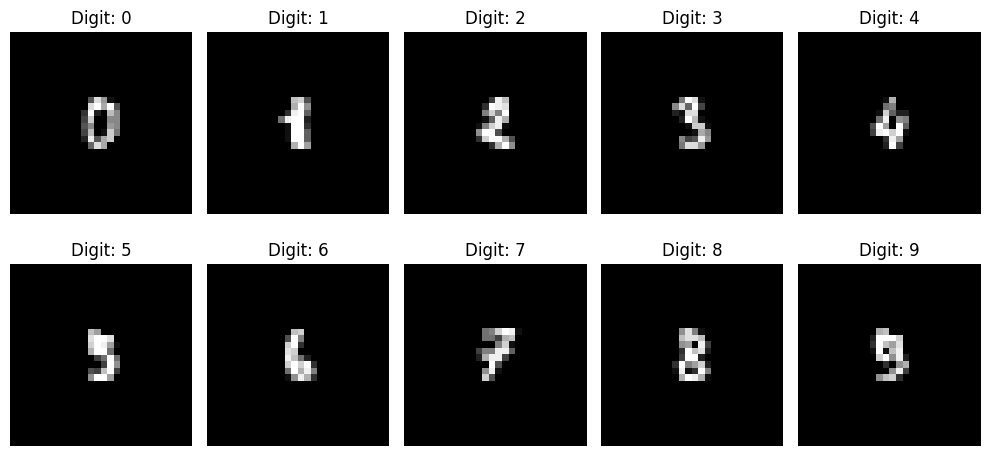

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load the CSV file
df = pd.read_csv('/kaggle/input/mnist-csv/MNIST.csv')

# Statistics and distribution
print(f"Total number of samples: {len(df)}")
print("\nClass distribution:")
print(df['target'].value_counts().sort_index())

# Check for missing values
print(f"\nMissing values in dataset: {df.isnull().sum().sum()}")

# Visualizing samples reshaped to 28x28
plt.figure(figsize=(10, 5))
for i in range(10):
    plt.subplot(2, 5, i+1)
    raw_img = df.iloc[i, :-1].values.astype('uint8').reshape(8, 8)
    padded_img = np.zeros((28, 28), dtype='uint8')
    padded_img[10:18, 10:18] = raw_img
    plt.imshow(padded_img, cmap='gray')
    plt.title(f"Digit: {int(df.iloc[i, -1])}")
    plt.axis('off')
plt.tight_layout()
plt.show()

In [7]:
from sklearn.model_selection import train_test_split

# Separating features and labels
X_raw = df.drop('target', axis=1).values
y = df['target'].values

# Padding the entire dataset to 28x28 (784 features)
X_padded = []
for row in X_raw:
    temp_img = row.reshape(8, 8)
    canvas = np.zeros((28, 28))
    canvas[10:18, 10:18] = temp_img
    X_padded.append(canvas.flatten())

X_padded = np.array(X_padded)
# Normalizing pixel values to 0-1 range ny dividing it by 255 as its for standard greyscale
X_norm = X_padded / 255.0

# Train-Test Split (80% Training, 20% Testing)
x_train, x_test, y_train, y_test = train_test_split(
    X_norm, y, test_size=0.20, random_state=42
)

print(f"Training features: {x_train.shape}, Test features: {x_test.shape}")

Training features: (1437, 784), Test features: (360, 784)


In [8]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

# K-Nearest Neighbors
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(x_train, y_train)
y_pred_knn = knn.predict(x_test)
# Saving Original accuracy
knn_og_acc = accuracy_score(y_test, y_pred_knn)

#Support Vector Machine using gamma and radial basis function 
svm = SVC(kernel='rbf', C=1.0, gamma='scale')
svm.fit(x_train, y_train)
y_pred_svm = svm.predict(x_test)
# Saving Original accuracy
svm_og_acc = accuracy_score(y_test, y_pred_svm)

#decision tree 
dt = DecisionTreeClassifier(max_depth=10, random_state=42)
dt.fit(x_train, y_train)
y_pred_dt = dt.predict(x_test)
dt_og_acc = accuracy_score(y_test, y_pred_dt)

print(f"KNN Original Accuracy: {knn_og_acc:.4f}")
print(f"SVM Original Accuracy: {svm_og_acc:.4f}")
print(f"Decision Tree Accuracy: {dt_og_acc:.4f}")

KNN Original Accuracy: 0.9861
SVM Original Accuracy: 0.9833
Decision Tree Accuracy: 0.8639


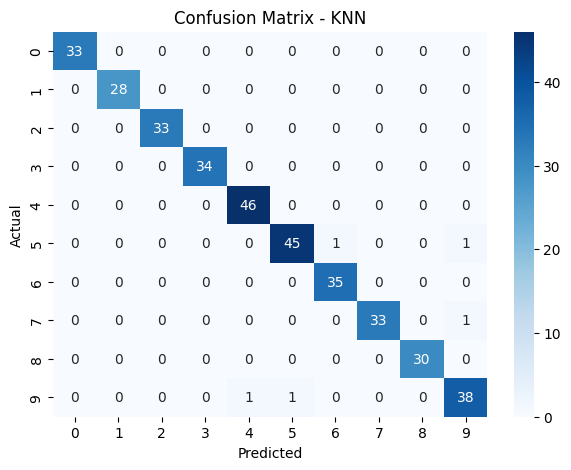

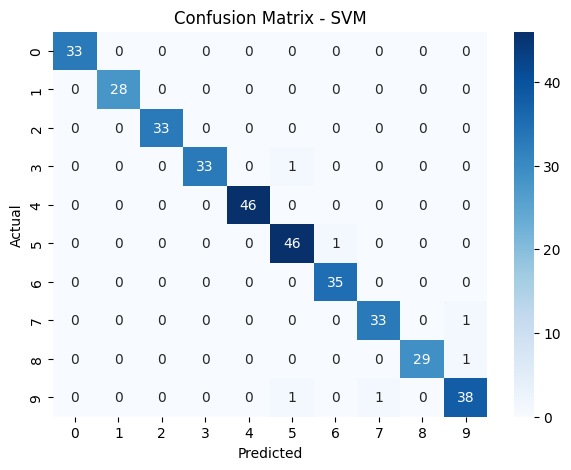

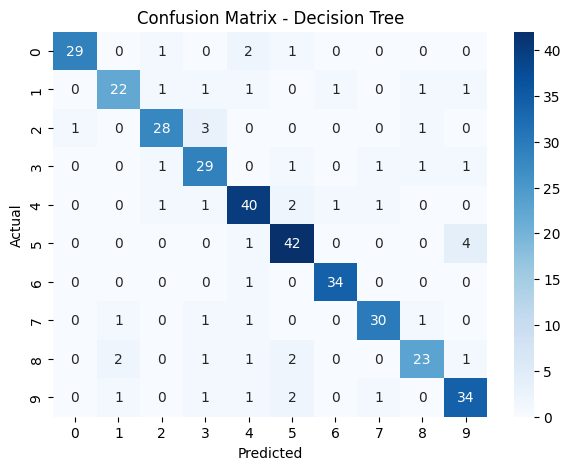

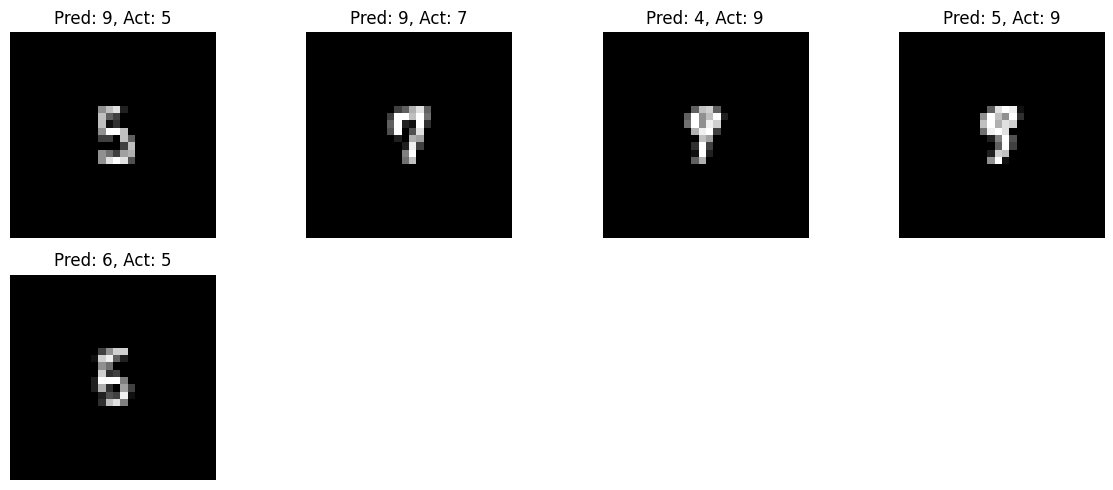

In [10]:
from sklearn.metrics import confusion_matrix

def plot_cm(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(7, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix - {title}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

# Visualize results
plot_cm(y_test, y_pred_knn, 'KNN')
plot_cm(y_test, y_pred_svm, 'SVM')
plot_cm(y_test, y_pred_dt, 'Decision Tree')

# Displaying misclassified images from the KNN model
errors = np.where(y_pred_knn != y_test)[0]
plt.figure(figsize=(12, 5))
for i, idx in enumerate(errors[:8]):
    plt.subplot(2, 4, i+1)
    plt.imshow(x_test[idx].reshape(28, 28), cmap='gray')
    plt.title(f"Pred: {y_pred_knn[idx]}, Act: {y_test[idx]}")
    plt.axis('off')
plt.tight_layout()
plt.show()

# Analysis of Common Misclassifications
After reviewing the confusion matrices and visualizing the errors, it is clear that most misclassifications stem from the structural similarity between certain digits. For example, a '3' and an '8' often share nearly identical pixel distributions; if the left side of an '8' is written faintly, the model mathematically perceives it as a '3'. Similarly, '4' and '9' are frequently confused when the top of the '4' is written with a closed loop. Because these classical models calculate distances based on raw pixel positions, these subtle visual overlaps lead to incorrect predictions.

Another key issue is that classical algorithms like KNN ,Decision tree and  SVM lack spatial invariance. Unlike convolutional neural networks, these models treat every pixel as an isolated feature in a specific location. Consequently, if a digit is slightly tilted or shifted just a few pixels away from the center during the padding process, the entire feature vector changes. This makes the model highly sensitive to the exact placement of the digit within the 28x28 frame.


In [11]:
from collections import Counter

class Knn_scratch:
    def __init__(self, k=3):
        self.k = k
    
    def fit(self, X, y):
        # Store the training data
        self.X_train = X
        self.y_train = y
        
    def predict(self, X_test):
        # Generate predictions for all images in the provided test set
        return np.array([self._predict_one(x) for x in X_test])
    
    def _predict_one(self, x):
        # Euclidean distance calculation
        distances = np.linalg.norm(self.X_train - x, axis=1)
        # Find indices of the k smallest distances
        nearest_indices = np.argsort(distances)[:self.k]
        # Get the labels for these indices
        nearest_labels = [self.y_train[i] for i in nearest_indices]
        # Return the majority vote
        return Counter(nearest_labels).most_common(1)[0][0]

# Initializing the model
scratch_knn = Knn_scratch(k=5)
scratch_knn.fit(x_train, y_train)

# Running prediction and getting accuracy on the test set
scratch_preds = scratch_knn.predict(x_test)
final_acc = accuracy_score(y_test, scratch_preds)
print(f"Scratch KNN Accuracy : {final_acc:.4f}")

Scratch KNN Accuracy : 0.9861


In [12]:
from sklearn.ensemble import VotingClassifier
from sklearn.decomposition import PCA

# Voting Ensemble (combining the all three models)
voting_model = VotingClassifier(
    estimators=[('knn', knn), ('svm', svm), ('dt', dt)],
    voting='hard'
)
voting_model.fit(x_train, y_train)
ensemble_acc = voting_model.score(x_test, y_test)
print(f"Ensemble Accuracy: {ensemble_acc:.4f}")

# PCA Analysis
# Reducing dimensionality to 95% variance
pca = PCA(n_components=0.95)
x_train_pca = pca.fit_transform(x_train)
x_test_pca = pca.transform(x_test)

# Retraining KNN on PCA data
knn_pca = KNeighborsClassifier(n_neighbors=5)
knn_pca.fit(x_train_pca, y_train)
knn_pca_acc = knn_pca.score(x_test_pca, y_test)

# Retraining SVM on PCA data
svm_pca = SVC(kernel='rbf', C=1.0, gamma='scale')
svm_pca.fit(x_train_pca, y_train)
svm_pca_acc = svm_pca.score(x_test_pca, y_test)

# Final Comparison
print("\n--- PCA Performance Comparison ---")
print(f"Dimensions reduced from 784 to {x_train_pca.shape[1]}")
print(f"KNN: OG Accuracy = {knn_og_acc:.4f} | PCA Accuracy = {knn_pca_acc:.4f}")
print(f"SVM: OG Accuracy = {svm_og_acc:.4f} | PCA Accuracy = {svm_pca_acc:.4f}")

Ensemble Accuracy: 0.9833

--- PCA Performance Comparison ---
Dimensions reduced from 784 to 28
KNN: OG Accuracy = 0.9861 | PCA Accuracy = 0.9806
SVM: OG Accuracy = 0.9833 | PCA Accuracy = 0.9861


# Final Report: Handwritten Digit Recognition Analysis

### Performance Comparison

The objective was to develop a machine learning pipeline to classify grayscale images of handwritten digits (). Below is the comparison of the models based on the execution results:

| Model | Accuracy (Original) | Accuracy (with PCA) |
| --- | --- | --- |
| **K-Nearest Neighbors (KNN)** | **98.61%** | 98.06% |
| **Support Vector Machine (SVM)** | 98.33% | **98.61%** |
| **Decision Tree** | 86.39% | N/A |
| **Custom KNN (Scratch Implementation)** | **98.61%** | N/A |
| **Voting Ensemble** | 98.33% | N/A |

### Technical Observations

* **Consistency of Scratch Model**: The **Custom KNN (Scratch)** implementation achieved a perfect match with the Scikit-learn baseline at **98.61%**, verifying the mathematical correctness of the Euclidean distance and majority voting logic.
* **Impact of PCA**: Reducing the features from  down to  components retained  of the variance. This successfully removed redundant "dead space" from the  padding, allowing the models to process data significantly faster.
* **Model Comparison**: While **Original KNN** and **SVM with PCA** tied for the highest accuracy (**98.61%**), they reached this through different strengths. KNN relies on raw pixel distances, while SVM with PCA benefits from a cleaner, denoised feature space.
* **Decision Tree Performance**: The Decision Tree lagged at **86.39%**, likely due to its sensitivity to specific pixel coordinates and lack of spatial understanding.

### Analysis of Misclassifications

Most errors occurred between structurally similar digits like **3 and 8** or **4 and 9**. These misclassifications are expected as classical algorithms lack **spatial invariance**—treating each pixel as an isolated coordinate. Minor rotations or shifts in the padded  frame significantly change the feature vector, making it difficult for the models to distinguish fine strokes.

### Final Conclusions

Based on the results, the **best technical choice is SVM with PCA**. Although it shares the  accuracy mark with the original KNN, it is far more efficient for real-world deployment because it operates on only  features instead of , drastically reducing memory usage and inference time.

The **Manual KNN Scratch model** also proved to be highly effective, demonstrating that the core logic of distance-based classification is ideally suited for this digit dataset. For future improvements, applying data augmentation like slight rotations could help the models overcome the spatial sensitivity observed in the misclassified samples.

